In [79]:
import sys
sys.path.append("..")

import Essentials

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [81]:
data_archive = np.load('../Data_Average_Nikita.npz', allow_pickle=True)

In [82]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [83]:
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

In [84]:
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.2, random_state=10)

In [85]:
all_X_1.shape

(107, 87)

In [86]:
y_train, timestamp_train = prepare_Y(y_train)

In [87]:
y_test, timestamp_test = prepare_Y(y_test)

In [88]:
x_train.shape

(85, 87)

In [89]:
x_test.shape

(22, 87)

In [90]:
x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_2, y_winter_half_2, test_size=0.2, random_state=10)

In [91]:
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_2, y_summer_half_2, test_size=0.2, random_state=10)

In [92]:
y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)

In [93]:
y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)

In [94]:
y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)

In [95]:
y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)

In [96]:
class PCA_LR(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train):
        super().__init__(name)
        self.x_scaler = StandardScaler()
        self.x_pca = None  # Инициализация будет в методе tune_pca_components
        self.fit_scaler(x_train)

        # Поиск оптимального количества компонент
        self.tune_pca_components(x_train, y_train)

        # Обучение модели
        self.model = LinearRegression()
        self.train(x_train, y_train)
        self.set_model(self.model)

    def tune_pca_components(self, x_train, y_train):
        r2_scores = []
        for n_components in range(1, 40):
            pca = PCA(n_components=n_components)
            self.fit_pca(pca, x_train)
            pca_x_train = self.preprocessing(x_train)

            # Обучение модели на обучающей выборке с текущим количеством компонент
            model = LinearRegression()
            model.fit(pca_x_train, y_train)

            # Предсказание на обучающей выборке
            y_pred_train = model.predict(pca_x_train)

            # Расчёт R^2 на обучающей выборке и обновление списка r2_scores
            r2 = r2_score(y_train, y_pred_train)
            r2_scores.append(r2)

        # Определение числа компонент с максимальным R^2 на обучающей выборке
        optimal_n_components = np.argmax(r2_scores) + 1
        print(f"Оптимальное количество главных компонент (на основе обучающей выборки): {optimal_n_components}")

        # Обучение PCA с оптимальным числом компонент
        self.x_pca = PCA(n_components=optimal_n_components)
        self.x_pca.fit(self.x_scaler.transform(x_train))
    
    def preprocessing(self, x):
        try:
            x_scaled = self.x_scaler.transform(x)
            return self.x_pca.transform(x_scaled)
        except BaseException as err:
            print("Ошибка скейлера")
            raise err    
    
    def postprocessing(self, x):
        return x

    def fit_scaler(self, x):
        self.x_scaler.fit(x)

    def fit_pca(self, pca, x):
        scaled_x = self.x_scaler.transform(x)
        pca.fit(scaled_x)
        self.x_pca = pca
    
    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions

    def train(self, x_train, y_train):
        pca_x = self.preprocessing(x_train)
        self.model.fit(pca_x,y_train)

    def __str__(self):
        # Создание формулы для каждого коэффициента модели линейной регрессии
        pc_terms = [f"({coef:.6f}*PC{i+1})" for i, coef in enumerate(self.model.coef_.flatten())]
        # Формула линейной регрессии в формате y = (w1*PC1) + (w2*PC2) + ... + (wN*PCN) + intercept
        formula_str = " + ".join(pc_terms)  # Преобразование списка в одну строку
        
        intercept = self.model.intercept_
        # Для случая, когда перехват (intercept) является массивом
        if isinstance(intercept, np.ndarray):
            intercept = intercept.item(0)
        
        # Добавление перехвата (свободного члена) к общей формуле
        complete_formula = f"y = {formula_str} + {intercept:.6f}"
        
        return f"Линейная регрессия с PCA:\n{complete_formula}"

In [97]:
PCA_LR_test = PCA_LR("PCA_LR" ,x_train ,y_train)

Оптимальное количество главных компонент (на основе обучающей выборки): 39


In [98]:
metric = Essentials.R2Metric()

In [99]:
print(PCA_LR_test)

Линейная регрессия с PCA:
y = (0.313443*PC1) + (-0.232161*PC2) + (0.376245*PC3) + (0.545303*PC4) + (0.179243*PC5) + (0.282002*PC6) + (0.330893*PC7) + (-0.097665*PC8) + (-0.124469*PC9) + (0.178798*PC10) + (-0.241321*PC11) + (0.280571*PC12) + (-0.031371*PC13) + (-0.743688*PC14) + (-0.505037*PC15) + (-0.020385*PC16) + (-0.116544*PC17) + (0.366773*PC18) + (-0.339042*PC19) + (0.116807*PC20) + (0.895913*PC21) + (-0.000088*PC22) + (-0.507286*PC23) + (-0.760502*PC24) + (-0.320919*PC25) + (0.304040*PC26) + (0.219186*PC27) + (0.166698*PC28) + (-1.053392*PC29) + (0.131878*PC30) + (0.283778*PC31) + (1.287588*PC32) + (-1.575599*PC33) + (0.563405*PC34) + (0.416659*PC35) + (-0.868637*PC36) + (1.051866*PC37) + (-0.828467*PC38) + (1.077989*PC39) + 57.537647


In [100]:
PCA_LR_test.test(x_test, y_test, metric)

(array([[61.31530198],
        [59.14480341],
        [60.91094645],
        [49.73827956],
        [60.62072734],
        [58.2492864 ],
        [58.45983912],
        [59.24748517],
        [55.74212318],
        [56.65875965],
        [58.57855936],
        [54.72296456],
        [59.96371736],
        [56.47486866],
        [62.926055  ],
        [59.12147352],
        [53.2706786 ],
        [58.96601682],
        [55.85151   ],
        [51.11354603],
        [61.66154848],
        [57.2506988 ]]),
 0.7817688177778049)

In [101]:
PCA_LR_test_visual_train = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Linear with PCA SoftSensor R2 metric on Train')

        Coefficient of determination
PCA_LR                       0.87893


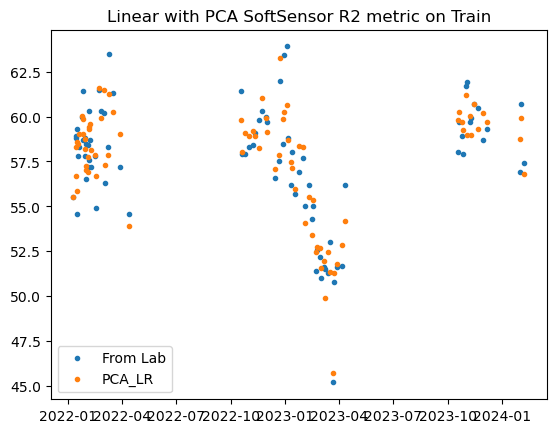

In [102]:
PCA_LR_test_visual_train.visualize([PCA_LR_test])

In [103]:
PCA_LR_test_visual_test = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'Linear with PCA SoftSensor R2 metric on Test')

        Coefficient of determination
PCA_LR                      0.781769


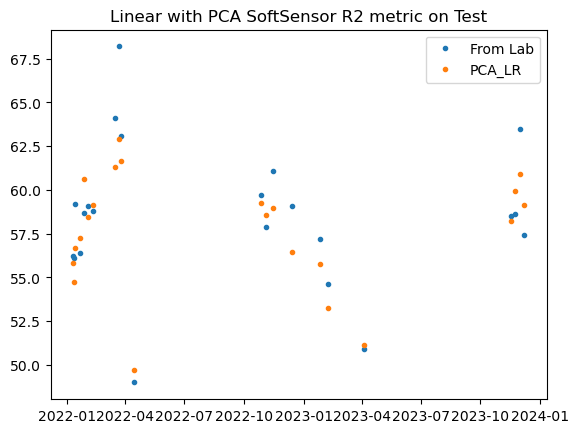

In [104]:
PCA_LR_test_visual_test.visualize([PCA_LR_test])